In [1]:
import numpy as np
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions

# Load the data sets

In [2]:
red_data = pd.read_csv('winequality-red.csv', sep=';')
red_data.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
white_data = pd.read_csv('winequality-white.csv', sep=';')
white_data.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6


# Explore the datasets
Check for N/A
Check the balance

In [4]:
red_data.isnull().all()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [5]:
white_data.isnull().all()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

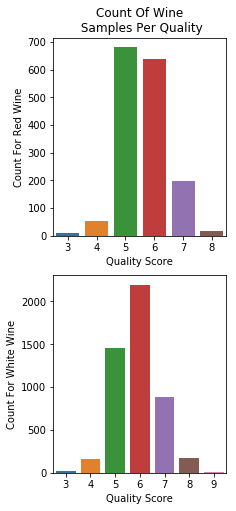

In [11]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
sns.countplot(x = 'quality', data = red_data, ax=axes[0])
sns.countplot(x = 'quality', data = white_data, ax=axes[1])
axes[0].set_title('Count Of Wine\n Samples Per Quality')
axes[1].set_ylabel('Count For White Wine')
axes[0].set_ylabel('Count For Red Wine')
axes[0].set_xlabel('Quality Score')
axes[1].set_xlabel('Quality Score')
plt.subplots_adjust(left=0.3)
fig.savefig('counts.png')
plt.show()

# Preprocess the datasets
The datasets are very unbalanced so to make it more like classification task we reduce tails a little bit

In [12]:
def transform_red(quality):
    if quality < 5:
        return 4
    if quality > 6:
        return 7
    return quality
def transform_white(quality):
    if quality < 5:
        return 4
    if quality > 7:
        return 8
    return quality

In [13]:
red_data['y'] = red_data['quality'].apply(transform_red)
white_data['y'] = white_data['quality'].apply(transform_white)

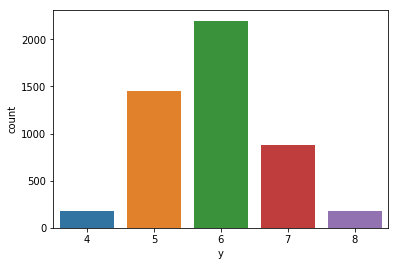

In [14]:
ax = sns.countplot(x = 'y', data = white_data)

Set up train and test data

In [15]:
y_red = red_data['y']
features = red_data.columns[:-2]
X_red = red_data[features]
print(red_data.shape)
print(y_red.shape)
print(X_red.shape)

(1599, 13)
(1599,)
(1599, 11)


In [16]:
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_red, y_red, test_size=0.3, random_state=111, stratify=y_red)
X_r_train.shape, y_r_train.shape

((1119, 11), (1119,))

In [17]:
y_white = white_data['y']
features = white_data.columns[:-2]
X_white = white_data[features]
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_white, y_white, test_size=0.3, random_state=111, stratify=y_white)
X_w_train.shape, y_w_train.shape

((3428, 11), (3428,))

## Let's try it with every feature available



In [18]:
result= pd.DataFrame(columns=['Classifier', 'Scaled', 'best_params', 'best_score', 'test_score'])

We are going to try several built-in classifiers on our datasets and use grid-search technique using 5 fold Cross-Validation to find optimal global parameters. 
Each classifier are going to be tryed on raw data and on scaled one to see what difference is there if any.

In [19]:
classifiers = [svm.SVC(), svm.SVC(), LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
               RandomForestClassifier()]
names = ['Linear SVM', 'RBF SVM', 'Logistic Regression', 'Nearest Neighbors', 'Decision Tree', 'Random Forest']
params =[{'kernel': ['linear'], 'C': [0.5, 1, 5]},
         {'kernel':['rbf'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100], 'gamma': [0.05, 0.1, 0.5, 1]},
         {'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
         {'n_neighbors': range(1, 21), 'leaf_size': range(5, 205, 5)},
         {'max_depth': range(1, 102, 5), 'min_samples_split': range(2,11)},
         {'max_depth': range(1, 102, 5), 'min_samples_split': range(2,11)}]

Define some helper functions

In [74]:
def fitGlobalParams(X_train, y_train, X_test, y_test, name, parameters, svr, scaled):
    clf = GridSearchCV(svr, parameters, cv=5, return_train_score=True)
    clf.fit(X_train, y_train)
    print('********************************************')
    print(name + 'scaled = ' + str(scaled))
    print('********************************************')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print('Best parameters:', clf.best_params_)
    print(clf.best_score_, accuracy_score(y_test, clf.predict(X_test)))
    result.loc[result.shape[0]]=[name, scaled, clf.best_params_,
                                 clf.best_score_, accuracy_score(y_test, clf.predict(X_test))]

def fitGP(X_train, y_train, X_test, y_test, name, parameters, svr):
    fitGlobalParams(X_train, y_train, X_test, y_test, name, parameters, svr, False)
    fitGlobalParams(StandardScaler().fit_transform(X_train), y_train, StandardScaler().fit_transform(X_test)
                    , y_test, name, parameters, svr, True)

In [21]:
def fitGPred(name, parameters, svr):
    fitGP(X_r_train, y_r_train, X_r_test, y_r_test, name, parameters, svr)

In [22]:
def fitGPwhite(name, parameters, svr):
    fitGP(X_w_train, y_w_train, X_w_test, y_w_test, name, parameters, svr)

In [75]:
for name, svr, param in zip(names, classifiers, params):
    fitGPred(name, param, svr)

********************************************
Linear SVMscaled = False
********************************************
Best parameters: {'C': 5, 'kernel': 'linear'}
0.5880250223413762 0.5583333333333333
********************************************
Linear SVMscaled = True
********************************************
Best parameters: {'C': 0.5, 'kernel': 'linear'}
0.5933869526362824 0.5583333333333333
********************************************
RBF SVMscaled = False
********************************************
Best parameters: {'C': 50, 'gamma': 0.5, 'kernel': 'rbf'}
0.5621090259159964 0.5916666666666667
********************************************
RBF SVMscaled = True
********************************************
Best parameters: {'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}
0.6407506702412868 0.6333333333333333
********************************************
Logistic Regressionscaled = False
********************************************
Best parameters: {'C': 0.5}
0.5889186773905273 0.58333333333333

Saving results on red wines

In [76]:
result_red = result.copy()

In [77]:
result = result.iloc[0:0]

In [78]:
result_red

,Classifier,Scaled,best_params,best_score,test_score
0,Linear SVM,False,"{'C': 5, 'kernel': 'linear'}",0.588025,0.558333
1,Linear SVM,True,"{'C': 0.5, 'kernel': 'linear'}",0.593387,0.558333
2,RBF SVM,False,"{'C': 50, 'gamma': 0.5, 'kernel': 'rbf'}",0.562109,0.591667
3,RBF SVM,True,"{'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}",0.640751,0.633333
4,Logistic Regression,False,{'C': 0.5},0.588919,0.583333
5,Logistic Regression,True,{'C': 5},0.596962,0.572917
6,Nearest Neighbors,False,"{'leaf_size': 5, 'n_neighbors': 1}",0.542449,0.583333
7,Nearest Neighbors,True,"{'leaf_size': 5, 'n_neighbors': 1}",0.615728,0.608333
8,Decision Tree,False,"{'max_depth': 66, 'min_samples_split': 5}",0.584450,0.597917
9,Decision Tree,True,"{'max_depth': 41, 'min_samples_split': 2}",0.586238,0.554167


Now let's run the same tests on white wine

In [79]:
for name, svr, param in zip(names, classifiers, params):
    fitGPwhite(name, param, svr)

********************************************
Linear SVMscaled = False
********************************************
Best parameters: {'C': 0.5, 'kernel': 'linear'}
0.5192532088681447 0.5238095238095238
********************************************
Linear SVMscaled = True
********************************************
Best parameters: {'C': 1, 'kernel': 'linear'}
0.5186697782963827 0.535374149659864
********************************************
RBF SVMscaled = False
********************************************
Best parameters: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.5796382730455076 0.6027210884353742
********************************************
RBF SVMscaled = True
********************************************
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.617269544924154 0.6401360544217687
********************************************
Logistic Regressionscaled = False
********************************************
Best parameters: {'C': 50}
0.5242123687281214 0.5414965986394558
**

In [80]:
result_white = result.copy()
result = result.iloc[0:0]
result_white

,Classifier,Scaled,best_params,best_score,test_score
0,Linear SVM,False,"{'C': 0.5, 'kernel': 'linear'}",0.519253,0.523810
1,Linear SVM,True,"{'C': 1, 'kernel': 'linear'}",0.518670,0.535374
2,RBF SVM,False,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.579638,0.602721
3,RBF SVM,True,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.617270,0.640136
4,Logistic Regression,False,{'C': 50},0.524212,0.541497
5,Logistic Regression,True,{'C': 1},0.528296,0.542857
6,Nearest Neighbors,False,"{'leaf_size': 5, 'n_neighbors': 1}",0.529172,0.554422
7,Nearest Neighbors,True,"{'leaf_size': 5, 'n_neighbors': 1}",0.582847,0.634694
8,Decision Tree,False,"{'max_depth': 101, 'min_samples_split': 2}",0.565053,0.623129
9,Decision Tree,True,"{'max_depth': 46, 'min_samples_split': 2}",0.564469,0.573469


In [26]:
result_white.to_csv('result_white.csv')
result_red.to_csv('result_red.csv')

Due to random nature of Decision Tree and Random Forest the results loadad from the csv file could differ slightly from computed above.

In [81]:
result_red = pd.read_csv('result_red.csv', index_col=0)
result_white = pd.read_csv('result_white.csv', index_col=0)
result_white

,Classifier,Scaled,best_params,best_score,test_score
0,Linear SVM,False,"{'C': 0.5, 'kernel': 'linear'}",0.519253,0.523810
1,Linear SVM,True,"{'C': 1, 'kernel': 'linear'}",0.518670,0.535374
2,RBF SVM,False,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.579638,0.602721
3,RBF SVM,True,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.617270,0.640136
4,Logistic Regression,False,{'C': 50},0.524212,0.541497
5,Logistic Regression,True,{'C': 1},0.528296,0.542857
6,Nearest Neighbors,False,"{'leaf_size': 5, 'n_neighbors': 1}",0.529172,0.554422
7,Nearest Neighbors,True,"{'leaf_size': 5, 'n_neighbors': 1}",0.582847,0.634694
8,Decision Tree,False,"{'max_depth': 101, 'min_samples_split': 2}",0.563886,0.617687
9,Decision Tree,True,"{'max_depth': 71, 'min_samples_split': 2}",0.565928,0.575510


In [82]:
def get_score_table(result):
    r_scaled = result[result['Scaled']].copy()
    r_scaled = r_scaled.drop(['Scaled', 'best_params', 'best_score'], axis=1)
    r_not_scaled = result[(result['Scaled'] == False)].copy()
    r_not_scaled = r_not_scaled.drop(['Scaled', 'best_params', 'best_score'], axis=1)
    r_scaled.columns = ['Classifier', 'Test Scores for\n Normalized Data']
    r_not_scaled.columns = ['Classifier', 'Test Scores for\n Non Normalized Data']
    r = r_scaled.merge(r_not_scaled, on='Classifier', how='inner')
    r = r.set_index('Classifier')
    return r

In [83]:
get_score_table(result_red)

,Test Scores for Normalized Data,Test Scores for Non Normalized Data
Classifier,,
Linear SVM,0.558333,0.558333
RBF SVM,0.633333,0.591667
Logistic Regression,0.572917,0.583333
Nearest Neighbors,0.608333,0.583333
Decision Tree,0.535417,0.622917
Random Forest,0.618750,0.635417


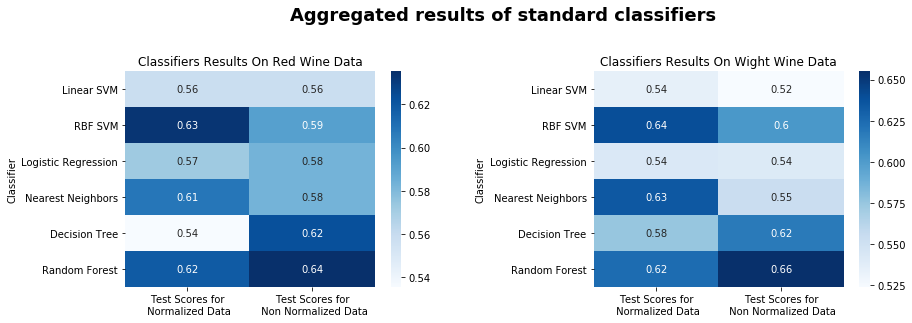

In [84]:
rr = get_score_table(result_red)
rw = get_score_table(result_white)
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(rr, annot=True, cmap='Blues', ax=axes[0])
sns.heatmap(rw, annot=True, cmap='Blues', ax=axes[1])
axes[0].set_title('Classifiers Results On Red Wine Data')
axes[1].set_title('Classifiers Results On Wight Wine Data')
plt.subplots_adjust(wspace=0.5, top=0.80, bottom=0.2)
fig.suptitle('Aggregated results of standard classifiers', fontweight='bold', size=18)
fig.savefig('test_results.png')
plt.show()

As expected we can see Standardization improving results for Support Vector Machine and Nearest Neighbor Classifiers and have no impact on tree based classifiers like Decision Tree and Random Forest.
Two classifiers have shown good results for both datasets: RBF SVM and Random Forest. Let's work with them a little bit more.
(Nearest neighbor also gave good result but only with n_neighbors = 1 thus it not looks very promising)

In [85]:
rfcWhite = RandomForestClassifier(max_depth=31, min_samples_split=2, random_state=13)
rfcRed = RandomForestClassifier(max_depth=41, min_samples_split=5, random_state=13)
svmWhite = svm.SVC(C=10, gamma=1, kernel='rbf')
svmRed = svm.SVC(C=5, gamma=0.5, kernel='rbf')
nnWhite = KNeighborsClassifier(leaf_size=5, n_neighbors=1)
nnRed = KNeighborsClassifier(leaf_size=5, n_neighbors=1)

In [86]:
rfcWhite.fit(X_w_train, y_w_train)
rfcRed.fit(X_r_train, y_r_train)
# We are going to need Scaled data for SVM Classifier:
X_w_train_scaled = StandardScaler().fit_transform(X_w_train)
X_w_test_scaled = StandardScaler().fit_transform(X_w_test)
X_r_train_scaled = StandardScaler().fit_transform(X_r_train)
X_r_test_scaled = StandardScaler().fit_transform(X_r_test)

svmWhite.fit(X_w_train_scaled, y_w_train)
svmRed.fit(X_r_train_scaled, y_r_train)
nnWhite.fit(X_w_train_scaled, y_w_train)
nnRed.fit(X_r_train_scaled, y_r_train)

print(rfcWhite.score(X_w_test, y_w_test), svmWhite.score(X_w_test_scaled, y_w_test), nnWhite.score(X_w_test_scaled, y_w_test))
print(rfcRed.score(X_r_test, y_r_test), svmRed.score(X_r_test_scaled, y_r_test), nnRed.score(X_r_test_scaled, y_r_test))

0.6428571428571429 0.6401360544217687 0.6346938775510204
0.625 0.6333333333333333 0.6083333333333333


Thus we have 3 decent classifiers for our datasets. All of them based on different approaches in machine learning techniques: Support Vector Machine, Decision Trees and Nearest Neighbors. It looks obvious to suggest that there could be a way to benefit from this fact and we will try the simple voting approach.
Our voteClassifier going to choose median of 3 predictions based on SVM, Random Forest and Nearest Neighbors.

So for white wine:

In [87]:
def vote_white(X):
    Y = pd.DataFrame()
    Y['rf'] = rfcWhite.predict(X)
    Y['svm'] = svmWhite.predict(StandardScaler().fit_transform(X))
    Y['nn'] = nnWhite.predict(StandardScaler().fit_transform(X))
    return np.array(Y.median(axis=1).apply(lambda x: int(x)))

def vote_red(X):
    Y = pd.DataFrame()
    Y['rf'] = rfcRed.predict(X)
    Y['svm'] = svmRed.predict(StandardScaler().fit_transform(X))
    Y['nn'] = nnRed.predict(StandardScaler().fit_transform(X))
    return np.array(Y.median(axis=1).apply(lambda x: int(x)))

In [88]:
accuracy_score(y_w_test, vote_white(X_w_test)), accuracy_score(y_r_test, vote_red(X_r_test))

(0.6646258503401361, 0.6416666666666667)

We got better score for voteClassifier comparing to any of basis classifiers. But the difference not that big and could be just random event. Because there were non deterministic processes envolved in setting up training-testing datasets, tuning of random forest and defining the global parameters through grid-search technique. 

# Statistical evaluation of classifiers

Let's do standard statistical thing when dealing with stochastic processes and given that we chose strict algorithm of getting scores for each of the classifiers we are going to replicate this process many times and look at statistical measures of our statistics.

In [89]:
#Define lists where we're going to accumulate statistic values
rf_score = []
svm_score = []
nn_score = []
mv_score = [] #stands for our median voting classifier
#rf_best_params = []
#svm_best_params = []
predictions = pd.DataFrame()

To reduce computational time we shorten list of params in line with a few tests (left out of this notebook)

In [90]:
rf_params = {'max_depth': range(20, 101, 5), 'min_samples_split': range(2,8)}
svm_params = {'kernel':['rbf'], 'C': [1, 5, 10, 50], 'gamma': [0.5, 1]}

In [91]:
def get_scores(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    clf_svm = GridSearchCV(svm.SVC(), svm_params, cv=5, return_train_score=True)
    clf_svm.fit(X_train_scaled, y_train)
    predictions['svm'] = clf_svm.predict(X_test_scaled)
    svm_score.append(accuracy_score(y_test, predictions['svm']))
    #svm_best_params.append(clf_svm.best_params_)
    clf_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, return_train_score=True)
    clf_rf.fit(X_train, y_train)
    predictions['rf'] = clf_rf.predict(X_test)
    rf_score.append(accuracy_score(y_test, predictions['rf']))
    #rf_best_params.append(clf_rf.best_params_)
    clf_nn = KNeighborsClassifier(leaf_size=5, n_neighbors=1)
    clf_nn.fit(X_train_scaled, y_train)
    predictions['nn'] = clf_nn.predict(X_test_scaled)
    nn_score.append(accuracy_score(y_test, predictions['nn']))
    mv_score.append(accuracy_score(y_test, np.array(predictions.median(axis=1).apply(lambda x: int(x)))))

In [27]:
for i in range(500):
    start = time.clock()
    get_scores(X_white, y_white)
    if i % 10 == 0:
        print('%d: time spent: %f' % (i, time.clock() - start), end=' ')

0: time spent: 67.511934 10: time spent: 81.862915 20: time spent: 81.896749 30: time spent: 82.578034 40: time spent: 82.655424 50: time spent: 80.448173 60: time spent: 67.480281 70: time spent: 67.386512 80: time spent: 66.710976 90: time spent: 67.224641 100: time spent: 66.638305 110: time spent: 69.534755 120: time spent: 69.629152 130: time spent: 69.460484 140: time spent: 69.858440 150: time spent: 69.584802 160: time spent: 69.036476 170: time spent: 69.684819 180: time spent: 69.096412 190: time spent: 69.439174 200: time spent: 69.579246 210: time spent: 69.271503 220: time spent: 69.686563 230: time spent: 69.378300 240: time spent: 69.077716 250: time spent: 69.696302 260: time spent: 69.401725 270: time spent: 69.067499 280: time spent: 69.632999 290: time spent: 69.554278 300: time spent: 69.395944 310: time spent: 69.400072 320: time spent: 69.457661 330: time spent: 69.365516 340: time spent: 69.215869 350: time spent: 69.333826 360: time spent: 69.223677 370: time sp

In [53]:
scores = pd.DataFrame()
scores['SVM'] = svm_score
scores['Random Forest'] = rf_score
scores['Nearest Neighbor'] = nn_score
scores['Median Voter'] = mv_score
scores.to_csv('scores_white.csv')
scores.head()

,SVM,Random Forest,Nearest Neighbor,Median Voter
0,0.621088,0.621088,0.602721,0.636735
1,0.646259,0.639456,0.614966,0.657143
2,0.643537,0.649660,0.615646,0.657143
3,0.653741,0.646939,0.618367,0.666667
4,0.653741,0.638095,0.644218,0.670068


The same for Red Wine Data

In [26]:
#Define lists where we're going to accumulate statistic values
rf_score = []
svm_score = []
nn_score = []
mv_score = [] #stands for our median voting classifier
#rf_best_params = []
#svm_best_params = []
predictions = pd.DataFrame()

In [27]:
for i in range(1000):
    start = time.clock()
    get_scores(X_red, y_red)
    if i % 10 == 0:
        print('%d: time spent: %f' % (i, time.clock() - start), end=' ')

0: time spent: 18.444939 10: time spent: 18.341323 20: time spent: 18.530190 30: time spent: 18.373603 40: time spent: 18.360565 50: time spent: 18.816898 60: time spent: 18.311388 70: time spent: 18.884478 80: time spent: 18.466162 90: time spent: 18.367331 100: time spent: 18.716597 110: time spent: 18.482546 120: time spent: 18.517333 130: time spent: 18.480068 140: time spent: 18.536317 150: time spent: 18.499611 160: time spent: 18.524878 170: time spent: 18.633720 180: time spent: 18.561386 190: time spent: 18.389252 200: time spent: 18.554340 210: time spent: 18.674577 220: time spent: 18.534918 230: time spent: 18.703174 240: time spent: 18.589737 250: time spent: 18.567486 260: time spent: 18.452249 270: time spent: 18.504605 280: time spent: 18.621449 290: time spent: 18.393539 300: time spent: 18.433564 310: time spent: 18.517746 320: time spent: 18.549496 330: time spent: 18.787966 340: time spent: 18.495998 350: time spent: 18.516806 360: time spent: 18.878331 370: time sp

In [28]:
scores = pd.DataFrame()
scores['SVM'] = svm_score
scores['Random Forest'] = rf_score
scores['Nearest Neighbor'] = nn_score
scores['Median Voter'] = mv_score
scores.to_csv('scores_red.csv')
scores.head()

,SVM,Random Forest,Nearest Neighbor,Median Voter
0,0.616667,0.647917,0.589583,0.641667
1,0.662500,0.645833,0.629167,0.679167
2,0.652083,0.658333,0.620833,0.675000
3,0.625000,0.647917,0.616667,0.652083
4,0.627083,0.631250,0.606250,0.645833


In [92]:
white_scores = pd.read_csv('scores_white.csv', index_col=0)
red_scores = pd.read_csv('scores_red.csv', index_col=0)
print(white_scores.shape, red_scores.shape)
white_scores.head()

(500, 4) (1000, 4)


,SVM,Random Forest,Nearest Neighbor,Median Voter
0,0.643537,0.662585,0.623810,0.661905
1,0.660544,0.646259,0.627891,0.661905
2,0.642177,0.647619,0.611565,0.659184
3,0.652381,0.655102,0.633333,0.668707
4,0.656463,0.637415,0.634694,0.669388


In [93]:
white_scores.agg(['min', 'max', 'mean', 'std']).round(decimals=3)

,SVM,Random Forest,Nearest Neighbor,Median Voter
min,0.608,0.596,0.578,0.624
max,0.686,0.676,0.662,0.689
mean,0.644,0.640,0.622,0.657
std,0.012,0.012,0.012,0.011


In [94]:
red_scores.agg(['min', 'max', 'mean', 'std']).round(decimals=3)

,SVM,Random Forest,Nearest Neighbor,Median Voter
min,0.583,0.583,0.560,0.594
max,0.698,0.715,0.706,0.725
mean,0.643,0.656,0.628,0.665
std,0.019,0.020,0.020,0.021


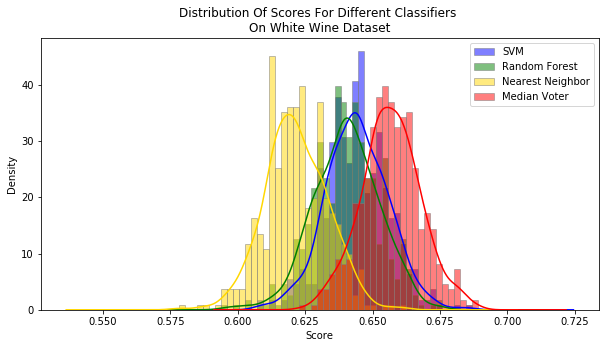

In [95]:
fig, ax = plt.subplots()
colors = ['blue', 'green', 'gold', 'red']
white_scores.plot.hist(density=True, bins=50, ax=ax, alpha=0.5,
                       title='Distribution Of Scores For Different Classifiers \nOn White Wine Dataset', edgecolor='grey',
                       figsize=(10,5), color=colors, histtype='bar')
white_scores.plot.kde(ax=ax, legend=False, color=colors)
ax.set_xlabel('Score')
fig.savefig('distributions.png')
plt.show()

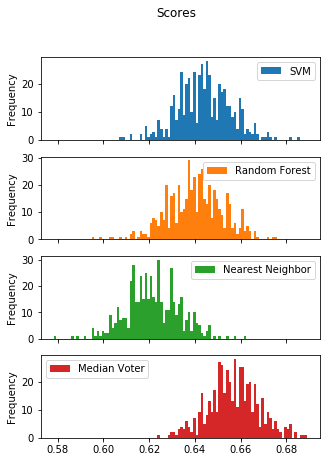

In [96]:
white_scores.plot(kind='hist', subplots=True, sharex=True, layout=(4,1)
                  , bins=100, figsize=(5,7), title='Scores', legend=True)
plt.show()

Percent when Random Forest achieved better result then Median Voter:

In [97]:
white_scores[white_scores['Random Forest'] > white_scores['Median Voter']].shape[0] * 1.0 / white_scores.shape[0]

0.054

Percent when SVM achieved better result then Median Voter:

In [98]:
white_scores[white_scores['SVM'] > white_scores['Median Voter']].shape[0] * 1.0 / white_scores.shape[0]

0.042

In [99]:
red_scores.agg(['min', 'max', 'mean', 'std']).round(decimals=3)

,SVM,Random Forest,Nearest Neighbor,Median Voter
min,0.583,0.583,0.560,0.594
max,0.698,0.715,0.706,0.725
mean,0.643,0.656,0.628,0.665
std,0.019,0.020,0.020,0.021


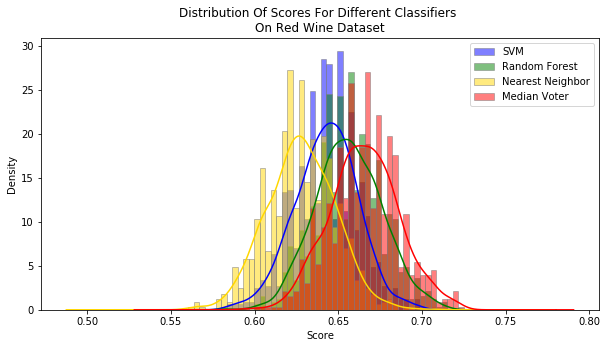

In [100]:
fig, ax = plt.subplots()
colors = ['blue', 'green', 'gold', 'red']
red_scores.plot.hist(density=True, bins=50, ax=ax, alpha=0.5,
                       title='Distribution Of Scores For Different Classifiers \nOn Red Wine Dataset', edgecolor='grey',
                       figsize=(10,5), color=colors, histtype='bar')
red_scores.plot.kde(ax=ax, legend=False, color=colors)
ax.set_xlabel('Score')
fig.savefig('distributions_red.png')
plt.show()

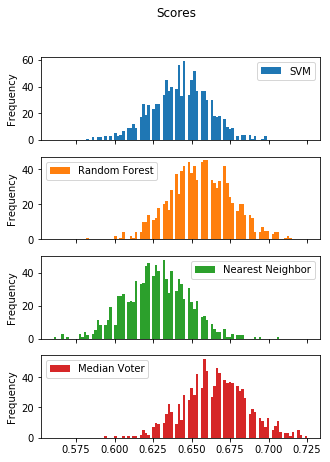

In [101]:
red_scores.plot(kind='hist', subplots=True, sharex=True, layout=(4,1)
                  , bins=100, figsize=(5,7), title='Scores', legend=True)
plt.show()

Percent when Random Forest achieved better result then Median Voter:

In [102]:
red_scores[red_scores['Random Forest'] > red_scores['Median Voter']].shape[0] * 1.0 / red_scores.shape[0]

0.28

Percent when SVM achieved better result then Median Voter:

In [103]:
red_scores[red_scores['SVM'] > red_scores['Median Voter']].shape[0] * 1.0 / red_scores.shape[0]

0.038

# Confusion Matrices

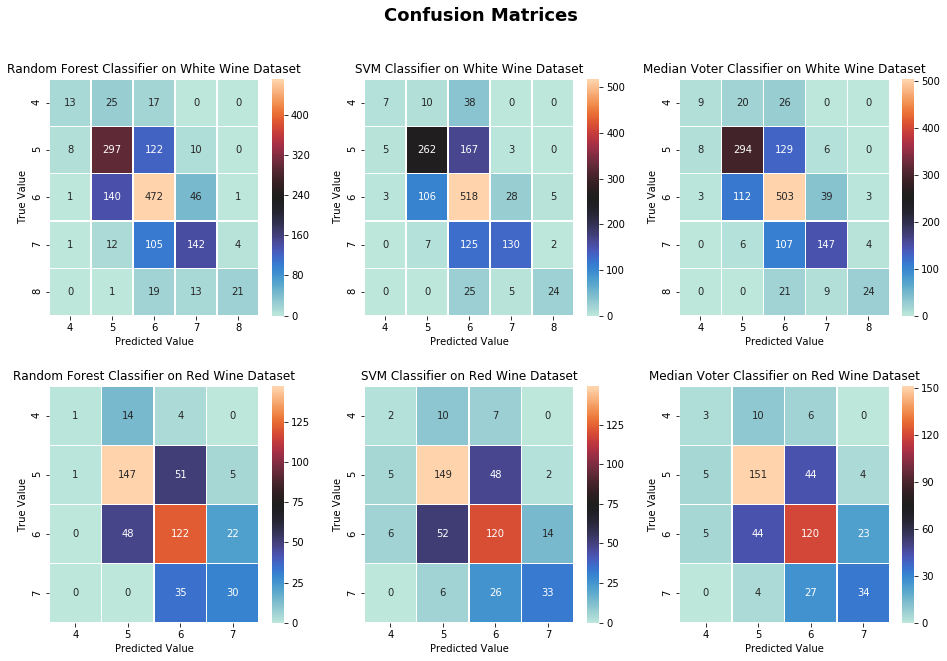

In [104]:
fig, axn = plt.subplots(2,3, figsize=(16,10))
cm_w_rfc = confusion_matrix(y_w_test, rfcWhite.predict(X_w_test))
cm_w_svm = confusion_matrix(y_w_test, svmWhite.predict(X_w_test_scaled))
cm_w_mv = confusion_matrix(y_w_test, vote_white(X_w_test))
cm_r_rfc = confusion_matrix(y_r_test, rfcRed.predict(X_r_test))
cm_r_svm = confusion_matrix(y_r_test, svmRed.predict(X_r_test_scaled))
cm_r_mv = confusion_matrix(y_r_test, vote_red(X_r_test))

sns.heatmap(pd.DataFrame(cm_w_rfc, index=[4,5,6,7,8], columns=[4,5,6,7,8])
                     , annot=True, fmt='d', ax=axn[0,0], linewidths=.5, cmap='icefire')
sns.heatmap(pd.DataFrame(cm_w_svm, index=[4,5,6,7,8], columns=[4,5,6,7,8])
                     , annot=True, fmt='d', ax=axn[0,1], linewidths=.5, cmap='icefire')
sns.heatmap(pd.DataFrame(cm_w_mv, index=[4,5,6,7,8], columns=[4,5,6,7,8])
                     , annot=True, fmt='d', ax=axn[0,2], linewidths=.5, cmap='icefire')

sns.heatmap(pd.DataFrame(cm_r_rfc, index=[4,5,6,7], columns=[4,5,6,7])
                     , annot=True, fmt='d', ax=axn[1,0], linewidths=.5, cmap='icefire')
sns.heatmap(pd.DataFrame(cm_r_svm, index=[4,5,6,7], columns=[4,5,6,7])
                     , annot=True, fmt='d', ax=axn[1,1], linewidths=.5, cmap='icefire')
sns.heatmap(pd.DataFrame(cm_r_mv, index=[4,5,6,7], columns=[4,5,6,7])
                     , annot=True, fmt='d', ax=axn[1,2], linewidths=.5, cmap='icefire')

axn[0,0].set_title('Random Forest Classifier on White Wine Dataset')
axn[0,1].set_title('SVM Classifier on White Wine Dataset')
axn[0,2].set_title('Median Voter Classifier on White Wine Dataset')
axn[1,0].set_title('Random Forest Classifier on Red Wine Dataset')
axn[1,1].set_title('SVM Classifier on Red Wine Dataset')
axn[1,2].set_title('Median Voter Classifier on Red Wine Dataset')

for ax in axn.flat:
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('True Value')
fig.suptitle('Confusion Matrices', fontweight='bold', size=18)
plt.subplots_adjust(hspace=0.3)
fig.savefig('confusion_matrices.png')
plt.show()

Let's compute precision of Median Voter Classifier for each predicted value:

In [105]:

def get_precision(matrix, max_error):
    result = []
    for i in range(len(matrix)):
        total = 0
        fit = 0
        for j in range(len(matrix)):
            total += matrix[j][i]
            if abs(i - j) <= max_error:
                fit += matrix[j][i]
        result.append(fit * 1.0 / total )
    return result

zero_tolerance_precision_w = get_precision(cm_w_mv, 0)
minimum_error_precision_w = get_precision(cm_w_mv, 1)
zero_tolerance_precision_r = get_precision(cm_r_mv, 0)
minimum_error_precision_r = get_precision(cm_r_mv, 1)
print(zero_tolerance_precision_w)
print(minimum_error_precision_w)
print(zero_tolerance_precision_r)
print(minimum_error_precision_r)          

[0.45, 0.6805555555555556, 0.6399491094147582, 0.7313432835820896, 0.7741935483870968]
[0.85, 0.9861111111111112, 0.9402035623409669, 0.9701492537313433, 0.9032258064516129]
[0.23076923076923078, 0.722488038277512, 0.6091370558375635, 0.5573770491803278]
[0.6153846153846154, 0.9808612440191388, 0.9695431472081218, 0.9344262295081968]


In [106]:
def more_then_one_error(cm):
    error = 0
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            if abs(i-j) > 1:
                error +=cm[i][j]
    return error/sum(map(sum,cm))
print(more_then_one_error(cm_w_rfc), more_then_one_error(cm_w_svm))
print(more_then_one_error(cm_r_rfc), more_then_one_error(cm_r_svm))

0.04217687074829932 0.05510204081632653
0.01875 0.04375


In [107]:
importances = rfcWhite.feature_importances_
importances

array([0.07513267, 0.09600149, 0.08645091, 0.08554785, 0.08840507,
       0.09684223, 0.0898061 , 0.1110535 , 0.08184911, 0.07771596,
       0.1111951 ])

In [108]:
X_w_train_weighted = X_w_train_scaled * (importances * importances) *100
X_w_test_weighted = X_w_test_scaled * (importances * importances) *100

In [109]:
X_w_train_scaled[:2, :]

array([[ 0.40716444,  0.32075776, -0.62527009,  0.173165  ,  0.18817121,
         0.10045864,  0.44439536,  0.73520901, -0.64187765, -0.51623972,
        -1.23084702],
       [-1.60974361, -0.47193043, -1.21574553, -0.82259497, -0.08579392,
         0.21804199,  0.53781817, -0.64790323,  0.02210032, -0.51623972,
        -0.07992413]])

In [110]:
X_w_train_weighted[:2, :]

array([[ 0.22984102,  0.29561953, -0.46731185,  0.12672966,  0.1470644 ,
         0.09421431,  0.3584109 ,  0.90672451, -0.43001164, -0.31179692,
        -1.52186225],
       [-0.90868719, -0.43494459, -0.90861902, -0.60201071, -0.06705187,
         0.20448889,  0.43375766, -0.79905133,  0.01480562, -0.31179692,
        -0.09882099]])

In [111]:
clf = GridSearchCV(svm.SVC(), {'kernel':['rbf'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100], 'gamma': [0.05, 0.1, 0.5, 1, 3]},
                   cv=5, return_train_score=True)
clf.fit(X_w_train_weighted, y_w_train)
print('Best parameters:', clf.best_params_)
print(clf.best_score_, accuracy_score(y_w_test, clf.predict(X_w_test_weighted)))

Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.6079346557759626 0.6428571428571429


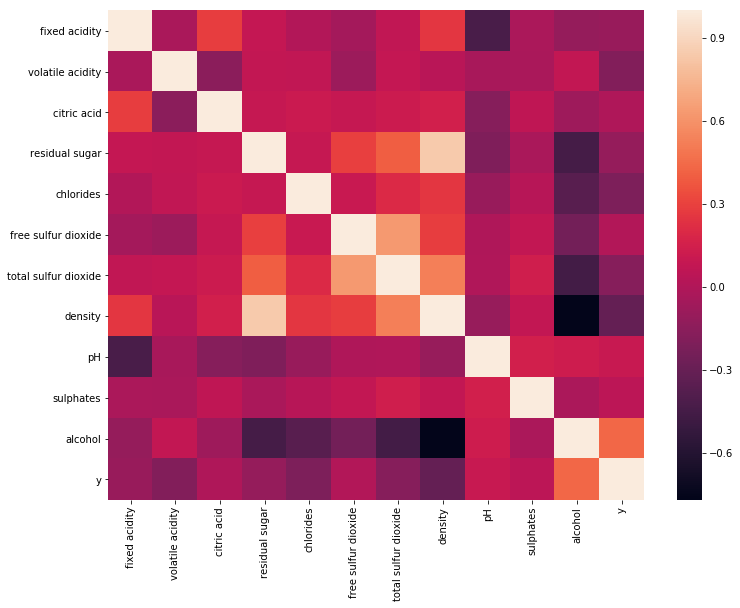

In [112]:
XY_w = X_w_train.copy()
XY_w['y'] = y_w_train
corrmat = XY_w.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

In [113]:
X_w_train_new = X_w_train.copy()
X_w_test_new = X_w_test.copy()
X_w_train_new.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
795,7.2,0.31,0.26,7.3,0.050,37.0,157.0,0.99625,3.09,0.43,9.0
4249,5.5,0.23,0.19,2.2,0.044,39.0,161.0,0.99209,3.19,0.43,10.4
3630,6.6,0.30,0.25,8.0,0.036,21.0,124.0,0.99362,3.06,0.38,10.8
418,7.4,0.21,0.27,1.2,0.041,27.0,99.0,0.99270,3.19,0.33,9.8
1389,8.1,0.19,0.40,0.9,0.037,73.0,180.0,0.99260,3.06,0.34,10.0


In [114]:
X = X_w_train_new.drop(['residual sugar','free sulfur dioxide'], axis=1)
X.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
795,7.2,0.31,0.26,0.050,157.0,0.99625,3.09,0.43,9.0
4249,5.5,0.23,0.19,0.044,161.0,0.99209,3.19,0.43,10.4
3630,6.6,0.30,0.25,0.036,124.0,0.99362,3.06,0.38,10.8
418,7.4,0.21,0.27,0.041,99.0,0.99270,3.19,0.33,9.8
1389,8.1,0.19,0.40,0.037,180.0,0.99260,3.06,0.34,10.0


In [115]:
X_test = X_w_test_new.drop(['residual sugar','free sulfur dioxide'], axis=1)

In [116]:
rf_params = {'max_depth': range(1, 102, 5), 'min_samples_split': range(2,11)}

In [117]:
fitGlobalParams(X, y_w_train, X_test, y_w_test, 'Random Forest', rf_params, RandomForestClassifier(), False)

********************************************
Random Forestscaled = False
********************************************
Best parameters: {'max_depth': 26, 'min_samples_split': 2}
0.6233955659276547 0.6428571428571429


In [119]:
def rfGPfit(X_train, y_train, name):
    clf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, return_train_score=True)
    clf.fit(X_train, y_train)
    print(name, 'Best parameters:', clf.best_params_, 'Score: ', clf.best_score_)

<function matplotlib.pyplot.show(*args, **kw)>

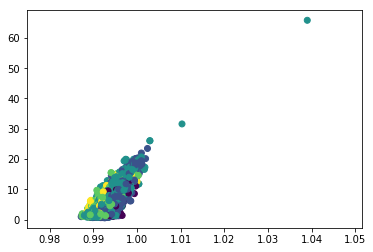

In [120]:
plt.scatter(XY_w['density'], XY_w['residual sugar'], c=y_w_train)
plt.legend = True
plt.show

In [121]:
XY_w[XY_w['density'] > 1.005]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,y
1653,7.9,0.330,0.28,31.6,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
2781,7.8,0.965,0.60,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


In [122]:
XY_w2 = XY_w[XY_w['density'] < 1.005].copy()

<function matplotlib.pyplot.show(*args, **kw)>

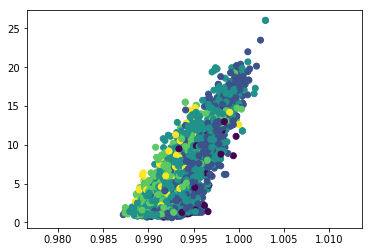

In [123]:
plt.scatter(XY_w2['density'], XY_w2['residual sugar'], c=XY_w2['y'])
plt.legend = True
plt.show

In [124]:
X_w2 = XY_w2[features]
y_w2 = XY_w2['y']
rfGPfit(X_w2, y_w2, 'cleaned')

cleaned Best parameters: {'max_depth': 21, 'min_samples_split': 2} Score:  0.6252189141856392


In [125]:
rfc_w2 = RandomForestClassifier(max_depth=21, min_samples_split=2, random_state=17)

In [126]:
rfc_w2.fit(X_w2, y_w2)
rfc_w2.score(X_w_test, y_w_test)

0.654421768707483